# Define The Un-normalized Spectral Clustering Algorithm

## Import Librairies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

## Define Gaussian Kernel

In [2]:
def gaussian_kernel(y1, y2, β1, β2):
    return np.exp(-np.linalg.norm(y1 - y2)**2 / (β1 * β2))

## Estimate β

In [3]:
def compute_β(V, y, M):
    assert M <= len(V), "M must be at most len(V)"
    norm_list = [np.linalg.norm(vi-y) for vi in V]
    norm_list.sort()
    return np.sum(norm_list[:M]) / M

## Compute Similarity Matrix 

In [4]:
def compute_similarity_matrix(similarity_function="gaussian", **kw_args):
    if similarity_function=="gaussian":
        V, M = kw_args["compute_β"]
        N = len(V)
        res = np.zeros((N, N))
        for i in range(N):
            for j in range(i+1, N):
                βi = compute_β(V, V[i], M)
                βj = compute_β(V, V[j], M)
                loc_value = gaussian_kernel(V[i], V[j], βi, βj)
                res[i, j] = loc_value
                res[j, i] = loc_value
        return res
    else: #p-value
        pass

def compute_D(similarity_matrix):
    return np.diag(np.sum(similarity_matrix, axis=1))

def compute_lagrangian(similarity_function="gaussian", **kw_args):
    S = compute_similarity_matrix(similarity_function=similarity_function, **kw_args)
    D = compute_D(S)
    return D - S

def compute_k_clusters(k, similarity_function="gaussian", **kw_args):
    L = compute_lagrangian(similarity_function=similarity_function, **kw_args)
    val, vec = np.linalg.eig(L)
    # sort eigenvalues
    idx = val.argsort()
    val = val[idx]
    vec = vec[:, idx]
    # take the eigenvectors corresponding to the k smallest eigenvalues
    U = vec[:, :k]
    kmeans = KMeans(n_clusters = k, n_init=10)
    kmeans.fit(U)
    return kmeans.predict(U)

# UserWarning about memory leak with MKL on Windows --------------------------------
import os
os.environ["OMP_NUM_THREADS"] = "1"
# -----------------------------------------------------------------------------------

def compute_clusters(eigen_threshold, similarity_function="gaussian", **kw_args):
    L = compute_lagrangian(similarity_function=similarity_function, **kw_args)
    val, vec = np.linalg.eig(L)
    U = vec[:, val < eigen_threshold]
    kmeans = KMeans(n_clusters = U.shape[1])
    kmeans.fit(U)
    return kmeans.predict(U)

## Generate Data 

In [5]:
def observe_rand_circles(ns, *R):
    res = np.zeros((ns, 2))
    for i in range(ns):
        θ = np.random.rand() * 2 * np.pi
        coin_flip = np.random.randint(2)
        r = np.random.choice(R)
        res[i, 0] = r * np.cos(θ)
        res[i, 1] = r * np.sin(θ)
    return res

def observe_smooth_circles(ns, *R):
    nR = len(R)
    thres = ns // nR
    res = np.zeros((thres * nR, 2))
    for i in range(ns):
        
        θ = np.linspace(0, 2*np.pi, thres)
        
        for i in range(thres * nR):
            iR = i//thres
            iθ = i % thres
            res[i, 0] = R[iR] * np.cos(θ[iθ])
            res[i, 1] = R[iR] * np.sin(θ[iθ])
    return res

## Add different noise levels to the data

Text(0.5, 1.0, 'Clear data')

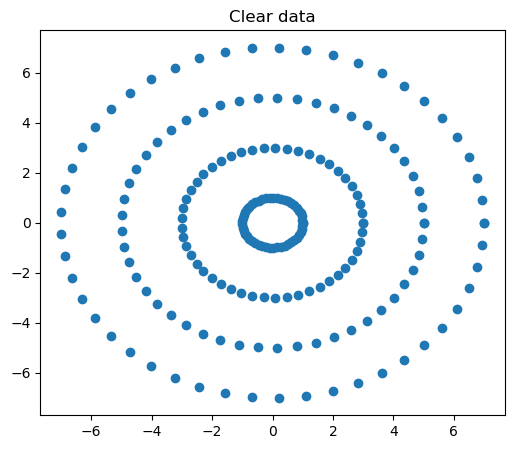

In [6]:
sigma = 0.03
clear_obs = observe_smooth_circles(200,1,3,5,7)
plt.figure(figsize=(6, 5))
# plot clear data
plt.scatter(clear_obs[:, 0], clear_obs[:, 1])
plt.title("Clear data")


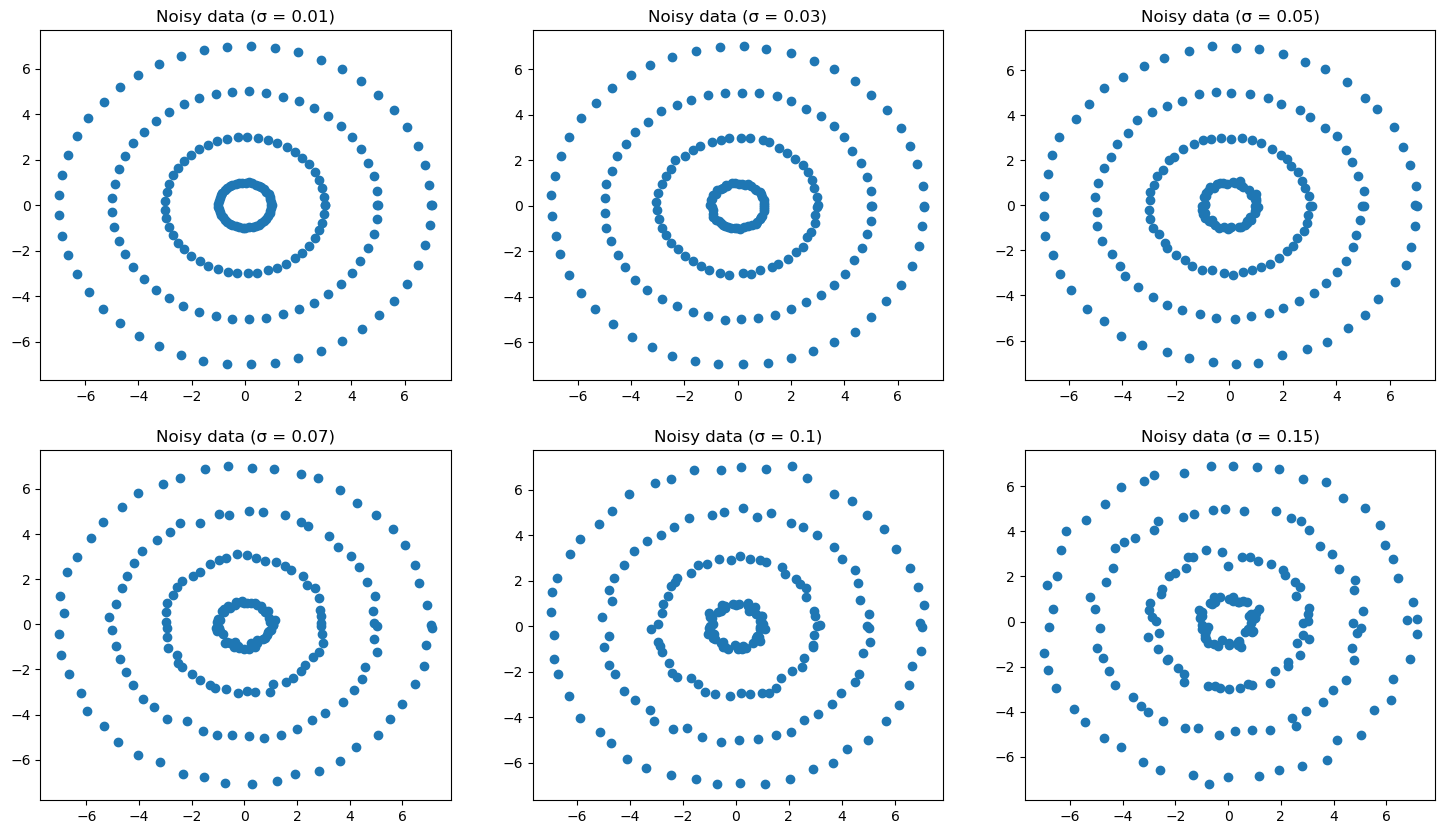

In [7]:
# create a list of obs for different values of σ
obs_list = []
sigma_list = [0.01, 0.03, 0.05, 0.07, 0.1, 0.15]
for sigma in sigma_list:
    obs_list.append(clear_obs + np.random.normal(0, sigma, clear_obs.shape))

# loop over the list of obs and plot the the noisy data
plt.figure(figsize=(18, 10))
for i, obs in enumerate(obs_list):
    plt.subplot(2, 3, i+1)
    plt.scatter(obs[:, 0], obs[:, 1])
    plt.title("Noisy data (σ = {})".format(sigma_list[i]))
plt.show()

## Testing Noise Effect in case K is known 

In [8]:
# loop over the obs_list and compute the kw_args for the compute_similarity_matrix function
kw_args_list = []
for obs in obs_list:
    kw_args_list.append({"compute_β":[obs, 3]})

c:\Programmes\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Programmes\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Programmes\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Programmes\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows wi

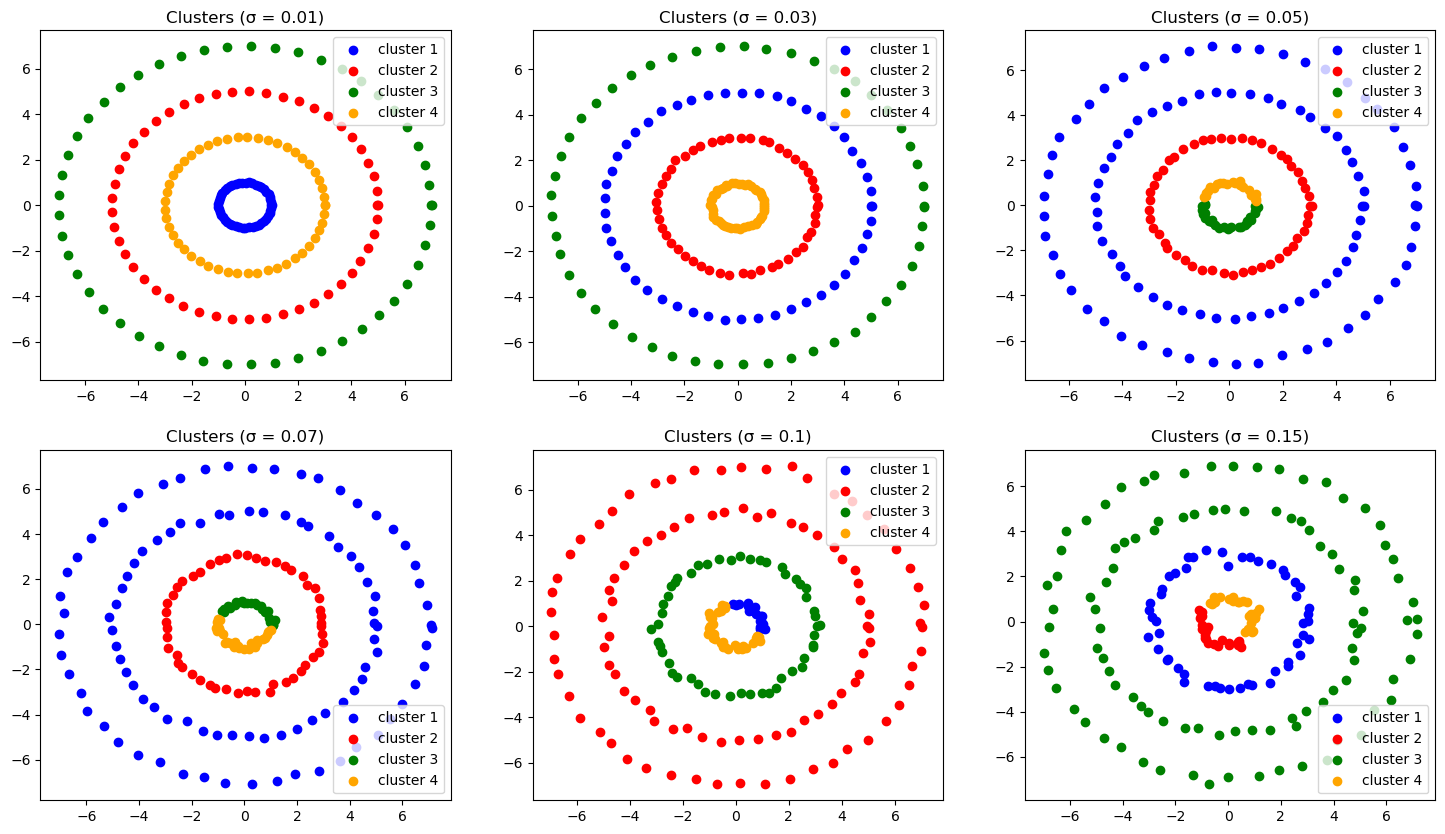

In [9]:
# loop over the obs_list and the kw_args_list and compute the k clusters
classes_algo_list = []
for kw_args in kw_args_list:
    classes_algo_list.append(compute_k_clusters(4, **kw_args))

# loop over the class_algo_list and the obs_list and plot the clusters
plt.figure(figsize=(18, 10))
for i, (classes_algo, obs) in enumerate(zip(classes_algo_list, obs_list)):
    plt.subplot(2, 3, i+1)
    A1auto = obs[classes_algo==0]
    A2auto = obs[classes_algo==1]
    A3auto = obs[classes_algo==2]
    A4auto = obs[classes_algo==3]    
    plt.scatter(A1auto[:, 0], A1auto[:, 1], c="blue", label="cluster 1")
    plt.scatter(A2auto[:, 0], A2auto[:, 1], c="red", label="cluster 2")
    plt.scatter(A3auto[:, 0], A3auto[:, 1], c="green", label="cluster 3")
    plt.scatter(A4auto[:, 0], A4auto[:, 1], c="orange", label="cluster 4")

    plt.legend()
    plt.title("Clusters (σ = {})".format(sigma_list[i]))
plt.show()

# DELETE LATER 

In [11]:
from sklearn import datasets
from sklearn import preprocessing

def create_data():
    X, z = datasets.make_moons(n_samples=200, noise=0.05, random_state=0)
    sc = preprocessing.StandardScaler()
    sc.fit(X)
    X_norm = sc.transform(X)
    return X_norm, z

c:\Programmes\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


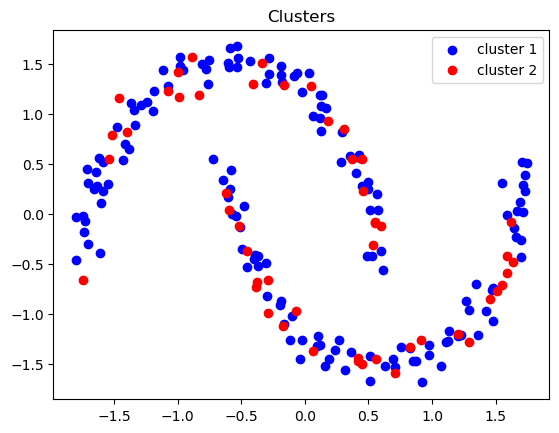

In [13]:
import numpy as np

X_norm, _ = create_data()

kw_args_list_X_norm = [{"compute_β":[obs, 3]}]

algo_X_norm = compute_k_clusters(2, **kw_args_list_X_norm[0])

A1auto = X_norm[algo_X_norm==0]
A2auto = X_norm[algo_X_norm==1]

plt.scatter(A1auto[:, 0], A1auto[:, 1], c="blue", label="cluster 1")
plt.scatter(A2auto[:, 0], A2auto[:, 1], c="red", label="cluster 2")
plt.legend()
plt.title("Clusters")
plt.show()